Today we're taking a break from our typical  hard hitting algorithm deep dives for a quick foray into the world of personal finance.
We'll take on a question I recently encountered while setting up my retirement account with my new employer—which is more efficient, the traditional 401(k) or the Roth 401(k)?
US-based readers will recognize these as the two main types of employer-sponsored retirement accounts.
When I searched for traditional vs Roth 401(k), the articles I found gave only very hand-wavy guidance on which is better in a given situation.
So, today I'll share my quantitative analysis of which account type provides superior performance for a given set of personal circumstances.
We'll implement the analysis in python, so you can run the numbers for your own situation and determine which employer-sponsored account type is better for you.


## Traditional 401(k) vs Roth 401(k)

I'll let JLCollins explain the [background on 401(k)s](https://jlcollinsnh.com/2015/06/02/stocks-part-viii-the-401k-403b-tsp-ira-roth-buckets/); 
read that post first if you're not already familiar with the concepts of taxable accounts, IRAs, 401(k)s, and the basic rules of Roth vs traditional.
The key distinction is
* In a traditional 401(k), money you contribute now is deducted from your taxable income, meaning you'll pay less in income tax now. During retirement however, withdrawals from the account will count toward your taxable income, so you'll pay tax then.
* In a Roth 401(k), money you contribute now does count toward your taxable income, meaning you'll pay income tax on any contributions now. During retirement however, withdrawals do not count toward your taxable income and are therefore tax free.

Essentially you can either pay tax now (Roth) or pay tax later (traditional).
The hand-wavy advice points out that which account is better for you depends on your income tax rate now versus your income tax rate during retirement.
High tax rate now and low tax rate during retirement could favor traditional, while low tax rate now and high tax rate during retirement could favor Roth.
Let's put some numbers on this advice.

I'll assume that you're following the [sage advice of Mr. Money Mustache](https://www.mrmoneymustache.com/2011/04/10/post-4-what-am-i-supposed-to-do-with-all-this-money/)
and (after paying off any high-interest debt) maxing out your 401(k) contribution for the year.
In 2024, the IRS has set a maximum combined contribution of $23,000; i.e. the sum of your Roth and traditional contributions cannot exceed this limit.
Also, once you contribute to these accounts, you may not begin withdrawals (without penalty) until the age of 59.5. 



## Analysis Formulation

Let's state the question precisely—which account type will yield me the most money during retirement after withdrawal and after all taxes are paid?
Let's think through the Roth vs traditional scenarios, setting aside the same amount of money today and liquidating the entire account at retirement; we'll compare how much money we have at retirement after liquidating and settling any tax obligations.

**Roth**: I contribute `contribution = 23_000` now, plus I pay income tax on this contribution in the amount of `current_income_tax_rate * contribution`. 
Over the years from now to retirement `retirement_age - current_age`, my contribution grows at some average long term yearly rate `investment_growth_rate`.
At retirement, I liquidate the entire account, paying no income tax on the proceeds.

**Traditional**: I contribute `contribution = 23_000` now. 
For fair comparison with the Roth, I invest an additional amount `current_income_tax_rate * contribution` (the extra income tax I would have paid had I chosen the Roth) in a normal taxable investment account as well.
Over the time from now to retirement, the 401(k) and the taxable account both grow at the average long term rate `investment_growth_rate`. 
However, in the taxable account, I'll also need to pay income tax every year on any dividends that I earn; the S&P500 has recently paid out 1.5-2% in dividends each year, let's call it `dividend_rate`.
At retirement, I liquidate both accounts, paying income tax on the proceeds from the 401(k) at the rate of `retirement_income_tax_rate` and paying capital gains tax on the proceeds from the taxable account at the rate of `retirement_capital_gains_tax_rate`.

Let's code up a function that takes in all our parameters and returns the total liquidation value after taxes of the Roth versus traditional 401(k)s as described above.



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
def get_401k_liquidation_value(
    current_age = 37,
    current_income_tax_rate = 0.35,
    contribution = 23_000,
    retirement_age = 59.5,
     investment_growth_rate = 0.07,
     dividend_rate = 0.02,
    retirement_income_tax_rate = 0.24,
    retirement_capital_gains_tax_rate = 0.15 # 0%, 15%, 20%
):

    investment_growth_factor = (1 + investment_growth_rate) ** (retirement_age - current_age)
    dividend_income_tax_drag_factor = (1 - dividend_rate * current_income_tax_rate) ** (retirement_age - current_age)

    # Roth 401k
    roth_401k_value = contribution 
    roth_401k_value *= investment_growth_factor
    total_roth_401k_liquidation_value = roth_401k_value
    
    # traditional  401k
    traditional_401k_value = contribution 
    taxable_account_value = current_income_tax_rate * contribution 
    traditional_401k_value *= investment_growth_factor
    taxable_account_value *= investment_growth_factor * dividend_income_tax_drag_factor
    traditional_401k_value *= (1 - retirement_income_tax_rate)
    taxable_account_value *= (1 - retirement_capital_gains_tax_rate)
    total_traditional_401k_liquidation_value = traditional_401k_value + taxable_account_value

    return {
        'traditional': round(total_traditional_401k_liquidation_value), 
        'roth': round(total_roth_401k_liquidation_value)
    }

In [3]:
get_401k_liquidation_value()

{'traditional': 106882, 'roth': 105405}

Somehow it's not surprising that these two options seem to yield very similar after-tax performance—no arbitrage right?

Let's write a function to perturb some of our parameter values to see under what conditions one option dominates the other.

In [4]:
def plot_liquidation_value_by_parameter_values(param, grid_values, func=get_401k_liquidation_value):
    y = [func(**{param: x}) for x in grid_values]
    df = pd.DataFrame(y, index=pd.Series(grid_values, name=param))
    fig, ax = plt.subplots()
    df.plot(ax=ax)
    plt.ylabel('liquidation value')
    plt.title(f'Liquidation Value at Retirement by {param}')
    return fig, ax

### Income Tax Rate at Retirement

It seems that income tax rate at retirement is by far the most important determining factor in whether traditional or Roth 401(k) is a better option.

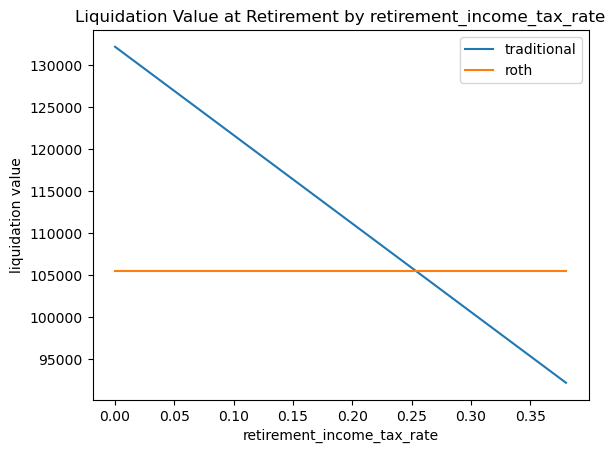

In [5]:
plot_liquidation_value_by_parameter_values('retirement_income_tax_rate', np.linspace(0, 0.38, num=20));

So given the other parameters I've set, Roth outperforms traditional when our income tax rate in retirement exceeds about 25%.
[According to the IRS](https://www.irs.gov/filing/federal-income-tax-rates-and-brackets)
in 2023, an individual tax payer is in the 24% bracket if their income is between about $95k and $180k.
So, how much income do you expect to pull in retirement?
If we're really building FIRE wealth, the kind indicated by Mr. Money Mustache and JLCollins, our income in retirement could easily exceed $180k, which would push us into the 32% bracket where Roth is more efficient than traditional.

### Capital Gains Tax Rate at Retirement

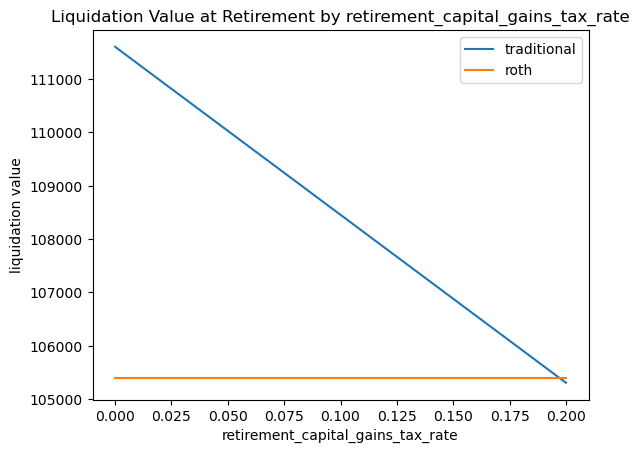

In [6]:
plot_liquidation_value_by_parameter_values('retirement_capital_gains_tax_rate', np.linspace(0, 0.20, num=20));

In 2023, [according to the IRS](https://www.irs.gov/filing/federal-income-tax-rates-and-brackets)
as a single tax payer, if your income is between $44k and $492k, you'll pay 15% capital gains.
Over $492k you'll jump up to 20% where Roth dominates traditional.

### Retirement Age

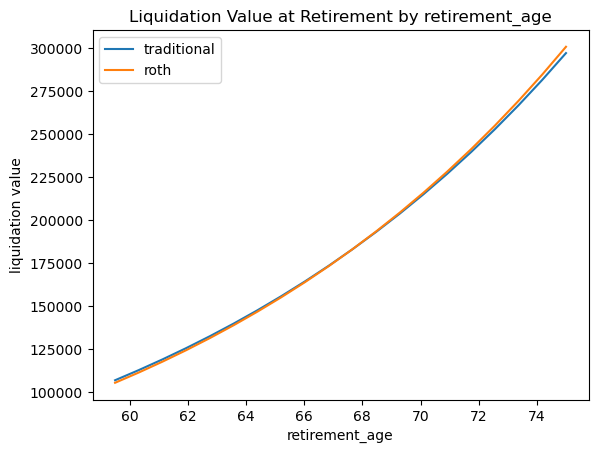

In [7]:
plot_liquidation_value_by_parameter_values('retirement_age', np.linspace(59.5, 75, num=20));

For retirement ages beyond 59.5, traditional's edge over Roth grows slightly.

## Bottom Line

Based on my assumptions and my particular parameters, the traditional and Roth 401(k)s have comparable post-retirement after-tax performance.
The most important factor is your income tax rate at the time of withdrawal during retirement, which is based on your taxable income at that time. 
In terms of current US tax policy and 2024 dollars, if your retirement income gets up to the $200k range, then parking your money now in the Roth 401(k) is the way to go, otherwise stick with the traditional 401(k).